In [40]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from copy import deepcopy
directory = "."
file_name = 'rdkit-II.npz'
random_seed = 2024
file_path = os.path.join(directory, file_name)

rdkit_II_npz = np.load(file_path, allow_pickle=True)

print("Arrays in the NPZ file:", rdkit-II_npz.files)
rdkit_II_data = rdkit_II_npz['data']
rdkit_II_columns = rdkit_II_npz['columns']
physorg_react_data_df = pd.DataFrame(rdkit_II_data, columns=rdkit_II_columns)

physorg_react_data_df.dropna(inplace=True) 

test_index = [87, 381, 316, 120, 479, 448, 197, 507, 198, 379, 508, 313, 265, 449, 453, 89, 292, 88, 121, 266, 454, 455, 447, 456, 271, 
              269, 294, 293, 297, 248, 249, 464, 312, 499, 289, 509, 511, 267, 166, 386, 290, 392, 498, 91, 488, 7, 278, 54, 285, 94, 303, 
              358, 444, 5, 286, 98, 458, 2, 291, 268, 470, 262, 308, 272, 53, 354, 512, 360, 495, 468, 391, 310, 307, 457, 306, 258, 352, 
              305, 357, 131, 362, 42, 311, 460, 304, 510, 298, 263, 350, 368, 100, 115, 61, 500, 56, 90, 442, 277, 487, 309, 0, 1, 356]

External_index = [462,119 ,396, 273, 375, 503, 318, 504, 472, 463, 465, 341, 342, 340, 477, 327, 348, 476,423 ,377, 332, 333, 182, 181,
                  349, 183, 112, 328, 323, 324, 113, 329, 330, 331, 144, 145,149, 150, 153, 151, 152, 154, 147, 485, 148, 482, 370, 373,
                  372, 146, 371]
length_db = len(physorg_react_data_df) // 2
            
test_index_db2 = [i + length_db for i in test_index]
External_index_db2 = [i + length_db for i in External_index]
all_indices = set(range(len(physorg_react_data_df)))  
train_val_indices = sorted(list(all_indices - set(test_index) - set(test_index_db2) - set(External_index) - set(External_index_db2)))
X = physorg_react_data_df.drop(columns=['YRed/Ox', 'compound_name'])
y = physorg_react_data_df['YRed/Ox']
X_train_val = X.iloc[train_val_indices]
y_train_val = y.iloc[train_val_indices]

scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)

Arrays in the NPZ file: ['data', 'columns']


# Fine screening of hyperparameters and mapping of learning curves

In [2]:
model = ExtraTreesRegressor(n_jobs=-1,random_state=random_seed)

param_grid = {
    'n_estimators': [350,400,450],
    'max_depth': [18,19,20,21,22],
    'min_samples_split': [2,4,5,6],
    'min_samples_leaf': [1, 2, 3]
}
kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)

grid_search = GridSearchCV(model, param_grid, scoring='r2', cv=kfold, verbose=2, n_jobs=-1)

grid_search.fit(X_train_val_scaled, y_train_val)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Best parameters: {'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 450}


In [3]:
rates = [int(i) for i in np.linspace(0.1, 0.9, 20) * X_train_val_scaled.shape[0]]
print(rates)

r2_list = []
r2_std_list = []
r2_train_list = []
r2_train_std_list = []

np.random.seed(random_seed)
model = ExtraTreesRegressor(n_jobs=-1, min_samples_split=4, min_samples_leaf=2, n_estimators=450, max_depth=19, random_state=random_seed)
kf = KFold(n_splits=10, random_state=random_seed, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_train_val_scaled, y_train_val, test_size=0.2, random_state=random_seed)
for rate in rates:
    r2s = []
    r2ts = []
    models = []
    y_pred = []
    maes = []
    rmses = []
    for train_index, val_index in kf.split(y_train):
        try:
            X_train_, X_test_, y_train_, y_test_ = train_test_split(
                X_train, y_train, train_size=rate)
        except:
            X_train_, y_train_ = X_train, y_train

        model.fit(X_train_, y_train_)
        models.append(deepcopy(model))
        y_pred.append(model.predict(X_test))
        valid_p, valid_y = model.predict(X_test), y_test
        r2 = r2_score(valid_y, valid_p)
        r2t = r2_score(model.predict(X_train_), y_train_)
        mae = mean_absolute_error(valid_y, valid_p)
        rmse = np.sqrt(mean_squared_error(valid_y, valid_p))
        r2s.append(r2)
        r2ts.append(r2t)
        maes.append(mae)
        rmses.append(rmse)
    
    valid_p, valid_y = np.array(y_pred).mean(axis=0), y_test
    r2 = np.array(r2s).mean(axis=0)
    r2_std = pd.DataFrame(r2s).std()[0]
    # print(r2_std)
    r2t = np.array(r2ts).mean(axis=0)
    r2t_std = pd.DataFrame(r2ts).std()[0]
    r2_list.append(r2)
    r2_train_list.append(r2t)
    r2_std_list.append(r2_std)
    r2_train_std_list.append(r2t_std)
    print(' $R^2$: {:.3}\n r2t: {:.3}\n r2std: {:.3}\n r2tstd: {:.3}'.format(
        r2, r2t, r2_std, r2t_std))
    
learning_curve = pd.DataFrame(columns=('r2', 'r2t', 'r2_std', 'r2t_std', 'num'))
learning_curve['r2'] = r2_list
learning_curve['r2t'] = r2_train_list
learning_curve['r2_std'] = r2_std_list
learning_curve['r2t_std'] = r2_train_std_list
learning_curve['num'] = rates
# learning_curve.to_csv('learn_curve.csv')
learning_curve

[73, 103, 134, 165, 195, 226, 257, 288, 318, 349, 380, 411, 441, 472, 503, 534, 564, 595, 626, 657]
 $R^2$: 0.897
 r2t: 0.996
 r2std: 0.015
 r2tstd: 0.00342
 $R^2$: 0.912
 r2t: 0.997
 r2std: 0.014
 r2tstd: 0.0012
 $R^2$: 0.921
 r2t: 0.996
 r2std: 0.0116
 r2tstd: 0.00159
 $R^2$: 0.924
 r2t: 0.997
 r2std: 0.00832
 r2tstd: 0.000932
 $R^2$: 0.93
 r2t: 0.997
 r2std: 0.00919
 r2tstd: 0.000972
 $R^2$: 0.937
 r2t: 0.997
 r2std: 0.00641
 r2tstd: 0.000922
 $R^2$: 0.939
 r2t: 0.998
 r2std: 0.00729
 r2tstd: 0.000605
 $R^2$: 0.942
 r2t: 0.998
 r2std: 0.0042
 r2tstd: 0.000906
 $R^2$: 0.946
 r2t: 0.997
 r2std: 0.00378
 r2tstd: 0.000625
 $R^2$: 0.946
 r2t: 0.998
 r2std: 0.00471
 r2tstd: 0.000239
 $R^2$: 0.95
 r2t: 0.998
 r2std: 0.00555
 r2tstd: 0.00055
 $R^2$: 0.95
 r2t: 0.998
 r2std: 0.00532
 r2tstd: 0.000292
 $R^2$: 0.951
 r2t: 0.998
 r2std: 0.0039
 r2tstd: 0.000428
 $R^2$: 0.954
 r2t: 0.998
 r2std: 0.00367
 r2tstd: 0.000371
 $R^2$: 0.956
 r2t: 0.998
 r2std: 0.00395
 r2tstd: 0.000241
 $R^2$: 0.956
 

,r2,r2t,r2_std,r2t_std,num
0,0.897076,0.995677,1.502389e-02,3.418325e-03,73
1,0.912336,0.997262,1.395835e-02,1.201233e-03,103
2,0.920913,0.996411,1.163925e-02,1.592331e-03,134
3,0.924443,0.997035,8.315836e-03,9.316408e-04,165
4,0.930083,0.997395,9.194855e-03,9.715656e-04,195
5,0.937074,0.996912,6.411082e-03,9.221238e-04,226
6,0.939296,0.997597,7.285989e-03,6.049653e-04,257
7,0.942025,0.997676,4.202053e-03,9.063502e-04,288
8,0.946108,0.997363,3.783336e-03,6.254115e-04,318
9,0.945726,0.997779,4.705490e-03,2.387638e-04,349


[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=2, n_estimators=350; total time=   1.0s
[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   1.3s
[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=2, n_estimators=450; total time=   1.4s
[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=4, n_estimators=350; total time=   1.1s
[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=4, n_estimators=400; total time=   1.0s
[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=6, n_estimators=350; total time=   0.8s
[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=6, n_estimators=400; total time=   0.9s
[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=6, n_estimators=400; total time=   0.9s
[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=6, n_estimators=450; total time=   0.9s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=2, n_estimators=350; total tim

[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=400; total time=   5.3s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=5, n_estimators=350; total time=   3.6s
[CV] END max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=450; total time=   5.2s
[CV] END max_depth=21, min_samples_leaf=1, min_samples_split=4, n_estimators=450; total time=   7.2s
[CV] END max_depth=21, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   4.9s
[CV] END max_depth=21, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   4.5s
[CV] END max_depth=21, min_samples_leaf=3, min_samples_split=2, n_estimators=350; total time=   2.9s
[CV] END max_depth=21, min_samples_leaf=3, min_samples_split=4, n_estimators=400; total time=   4.1s
[CV] END max_depth=21, min_samples_leaf=3, min_samples_split=6, n_estimators=400; total time=   4.8s
[CV] END max_depth=22, min_samples_leaf=1, min_samples_split=4, n_estimators=450; total tim

[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=4, n_estimators=450; total time=   7.4s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=6, n_estimators=400; total time=   6.0s
[CV] END max_depth=19, min_samples_leaf=1, min_samples_split=5, n_estimators=350; total time=   6.0s
[CV] END max_depth=19, min_samples_leaf=2, min_samples_split=2, n_estimators=350; total time=   4.7s
[CV] END max_depth=19, min_samples_leaf=2, min_samples_split=5, n_estimators=350; total time=   4.3s
[CV] END max_depth=19, min_samples_leaf=2, min_samples_split=6, n_estimators=450; total time=   5.2s
[CV] END max_depth=19, min_samples_leaf=3, min_samples_split=5, n_estimators=350; total time=   3.9s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=350; total time=   6.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   6.8s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=450; total tim

[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=5, n_estimators=450; total time=   4.8s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=5, n_estimators=350; total time=   3.6s
[CV] END max_depth=19, min_samples_leaf=1, min_samples_split=2, n_estimators=350; total time=   4.9s
[CV] END max_depth=19, min_samples_leaf=1, min_samples_split=5, n_estimators=350; total time=   5.5s
[CV] END max_depth=19, min_samples_leaf=2, min_samples_split=2, n_estimators=350; total time=   4.2s
[CV] END max_depth=19, min_samples_leaf=2, min_samples_split=4, n_estimators=400; total time=   5.7s
[CV] END max_depth=19, min_samples_leaf=2, min_samples_split=6, n_estimators=450; total time=   6.0s
[CV] END max_depth=19, min_samples_leaf=3, min_samples_split=5, n_estimators=450; total time=   5.3s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=4, n_estimators=350; total time=   6.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=6, n_estimators=350; total tim

[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=4, n_estimators=450; total time=   5.1s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=5, n_estimators=350; total time=   3.5s
[CV] END max_depth=19, min_samples_leaf=1, min_samples_split=2, n_estimators=350; total time=   6.4s
[CV] END max_depth=19, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   6.6s
[CV] END max_depth=19, min_samples_leaf=2, min_samples_split=2, n_estimators=450; total time=   5.8s
[CV] END max_depth=19, min_samples_leaf=2, min_samples_split=6, n_estimators=350; total time=   5.2s
[CV] END max_depth=19, min_samples_leaf=3, min_samples_split=4, n_estimators=400; total time=   4.2s
[CV] END max_depth=19, min_samples_leaf=3, min_samples_split=6, n_estimators=400; total time=   6.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=350; total time=   5.9s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=350; total tim

[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   2.9s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=2, n_estimators=450; total time=   2.6s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=4, n_estimators=400; total time=   0.8s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=4, n_estimators=450; total time=   2.3s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   0.7s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=5, n_estimators=450; total time=   2.4s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=6, n_estimators=400; total time=   1.8s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=2, n_estimators=350; total time=   3.7s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=2, n_estimators=450; total time=   5.3s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=5, n_estimators=450; total tim

[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   3.2s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=4, n_estimators=400; total time=   4.1s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=6, n_estimators=400; total time=   5.1s
[CV] END max_depth=19, min_samples_leaf=1, min_samples_split=4, n_estimators=400; total time=   5.6s
[CV] END max_depth=19, min_samples_leaf=1, min_samples_split=6, n_estimators=400; total time=   4.5s
[CV] END max_depth=19, min_samples_leaf=2, min_samples_split=4, n_estimators=350; total time=   4.5s
[CV] END max_depth=19, min_samples_leaf=2, min_samples_split=5, n_estimators=450; total time=   5.9s
[CV] END max_depth=19, min_samples_leaf=3, min_samples_split=4, n_estimators=400; total time=   4.6s
[CV] END max_depth=19, min_samples_leaf=3, min_samples_split=6, n_estimators=450; total time=   5.8s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=350; total tim

[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=2, n_estimators=350; total time=   1.2s
[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=2, n_estimators=450; total time=   1.3s
[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=2, n_estimators=450; total time=   0.9s
[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=2, n_estimators=450; total time=   1.4s
[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=4, n_estimators=400; total time=   1.1s
[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=6, n_estimators=350; total time=   0.8s
[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=6, n_estimators=400; total time=   0.9s
[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=6, n_estimators=400; total time=   0.9s
[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=6, n_estimators=450; total time=   1.0s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=2, n_estimators=350; total tim

[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=2, n_estimators=350; total time=   2.6s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=2, n_estimators=450; total time=   2.4s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=4, n_estimators=350; total time=   1.9s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=4, n_estimators=450; total time=   2.3s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=5, n_estimators=450; total time=   2.3s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=6, n_estimators=400; total time=   0.8s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=6, n_estimators=450; total time=   2.7s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=2, n_estimators=400; total time=   5.0s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=4, n_estimators=450; total time=   5.2s
[CV] END max_depth=19, min_samples_leaf=1, min_samples_split=2, n_estimators=350; total tim

[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=4, n_estimators=450; total time=   6.8s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=6, n_estimators=400; total time=   5.3s
[CV] END max_depth=19, min_samples_leaf=1, min_samples_split=4, n_estimators=450; total time=   5.5s
[CV] END max_depth=19, min_samples_leaf=1, min_samples_split=6, n_estimators=400; total time=   5.1s
[CV] END max_depth=19, min_samples_leaf=2, min_samples_split=4, n_estimators=400; total time=   4.9s
[CV] END max_depth=19, min_samples_leaf=2, min_samples_split=6, n_estimators=400; total time=   4.8s
[CV] END max_depth=19, min_samples_leaf=3, min_samples_split=4, n_estimators=400; total time=   4.1s
[CV] END max_depth=19, min_samples_leaf=3, min_samples_split=6, n_estimators=400; total time=   4.5s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=4, n_estimators=400; total time=   5.9s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=6, n_estimators=400; total tim

[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=4, n_estimators=400; total time=   5.2s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=4, n_estimators=350; total time=   3.5s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=5, n_estimators=400; total time=   4.4s
[CV] END max_depth=19, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   6.3s
[CV] END max_depth=19, min_samples_leaf=1, min_samples_split=5, n_estimators=450; total time=   7.4s
[CV] END max_depth=19, min_samples_leaf=2, min_samples_split=4, n_estimators=400; total time=   5.6s
[CV] END max_depth=19, min_samples_leaf=2, min_samples_split=6, n_estimators=450; total time=   4.8s
[CV] END max_depth=19, min_samples_leaf=3, min_samples_split=5, n_estimators=400; total time=   4.7s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   7.4s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=6, n_estimators=350; total tim

[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=2, n_estimators=350; total time=   2.4s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.8s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=4, n_estimators=350; total time=   1.9s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=4, n_estimators=450; total time=   2.3s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   2.1s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=6, n_estimators=350; total time=   1.5s
[CV] END max_depth=18, min_samples_leaf=2, min_samples_split=6, n_estimators=400; total time=   2.4s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=2, n_estimators=350; total time=   0.7s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=2, n_estimators=400; total time=   4.9s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=4, n_estimators=400; total tim

[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   4.8s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=5, n_estimators=350; total time=   3.8s
[CV] END max_depth=19, min_samples_leaf=1, min_samples_split=2, n_estimators=350; total time=   6.6s
[CV] END max_depth=19, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   6.5s
[CV] END max_depth=19, min_samples_leaf=2, min_samples_split=2, n_estimators=450; total time=   6.9s
[CV] END max_depth=19, min_samples_leaf=2, min_samples_split=6, n_estimators=450; total time=   4.9s
[CV] END max_depth=19, min_samples_leaf=3, min_samples_split=5, n_estimators=350; total time=   4.2s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=350; total time=   5.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=4, n_estimators=450; total time=   6.9s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total tim

[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=5, n_estimators=450; total time=   5.3s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=5, n_estimators=400; total time=   5.1s
[CV] END max_depth=19, min_samples_leaf=1, min_samples_split=2, n_estimators=450; total time=   7.5s
[CV] END max_depth=19, min_samples_leaf=1, min_samples_split=6, n_estimators=400; total time=   6.4s
[CV] END max_depth=19, min_samples_leaf=2, min_samples_split=5, n_estimators=350; total time=   4.2s
[CV] END max_depth=19, min_samples_leaf=2, min_samples_split=6, n_estimators=450; total time=   5.8s
[CV] END max_depth=19, min_samples_leaf=3, min_samples_split=5, n_estimators=450; total time=   5.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=450; total time=   7.3s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=6, n_estimators=400; total time=   5.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=400; total tim

[CV] END max_depth=18, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   5.8s
[CV] END max_depth=18, min_samples_leaf=3, min_samples_split=4, n_estimators=450; total time=   5.0s
[CV] END max_depth=19, min_samples_leaf=1, min_samples_split=2, n_estimators=350; total time=   6.9s
[CV] END max_depth=19, min_samples_leaf=1, min_samples_split=5, n_estimators=450; total time=   6.6s
[CV] END max_depth=19, min_samples_leaf=2, min_samples_split=4, n_estimators=350; total time=   4.2s
[CV] END max_depth=19, min_samples_leaf=2, min_samples_split=5, n_estimators=450; total time=   6.0s
[CV] END max_depth=19, min_samples_leaf=3, min_samples_split=4, n_estimators=400; total time=   4.4s
[CV] END max_depth=19, min_samples_leaf=3, min_samples_split=6, n_estimators=450; total time=   5.0s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=4, n_estimators=450; total time=   6.9s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=350; total tim

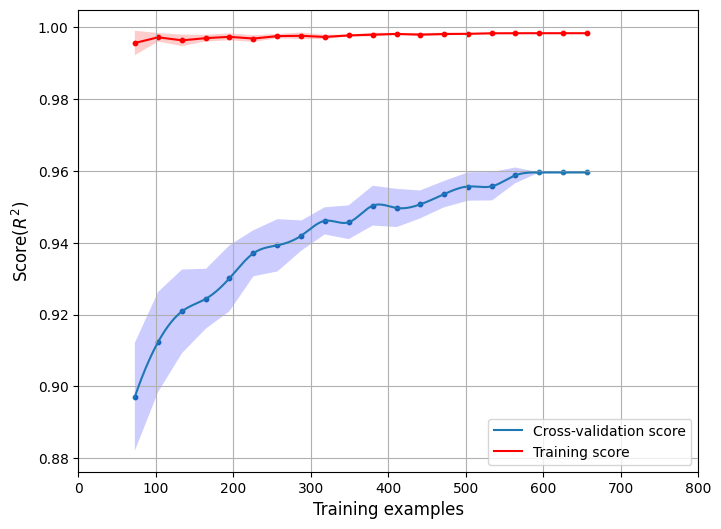

In [4]:
labels = rates 

min_label = min(labels)
max_label = max(labels)
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
r2 = learning_curve['r2']
r2t = learning_curve['r2t']
r2std = learning_curve['r2_std']
r2tstd = learning_curve['r2t_std']
labels = rates

xnew = np.linspace(min_label, max_label, 500)
func_1 = interp1d(labels, r2, kind='cubic')
r2_new = func_1(xnew)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(xnew,r2_new, '-', label = 'Cross-validation score')  
# ax.plot(labels, r2, '-', label = 'Cross-validation score')
ax.scatter(labels, r2, s=10)
ax.fill_between(labels, r2-r2std, r2+r2std, alpha=0.2, facecolor='b')


ax.plot(labels, r2t, '-r', label = 'Training score')
ax.scatter(labels, r2t, s=10, c='r')
ax.fill_between(labels, r2t-r2tstd, r2t+r2tstd, alpha=0.2, facecolor='r')
plt.xlim((0, 800))
plt.legend(loc='lower right')

ax.set_xlabel("Training examples", fontsize=12)
ax.set_ylabel("Score($R^2$)", fontsize=12)
ax.grid()
plt.savefig('./learning curve-PhO.png', dpi=600)

# Feature Engineering - Feature Screening

In [5]:
'''
The dataset is divided into training/validation and out-of-sample (OOS) test sets based on predefined indices. 
The division process ensures that the test data is completely held out during the training and validation phases 
to properly evaluate the model's performance on unseen data.

- `test_index`: This is the primary set of indices used to define the initial part of the OOS test set.
- `test_index_db2`: Additional test indices derived by adding half the length of the dataset (`length_db`) to each index in `test_index`.
  This approach accounts for the potential scenario where test data points are distributed across the dataset.

The following steps are executed in the code:
1. `length_db` is calculated as half the total number of data points, used to adjust the indices for the second half of the dataset.
2. `test_index_db2` is generated to cover any test data points that might appear in the latter half of the dataset.
3. `full_test_index` combines `test_index` and `test_index_db2` to form the complete set of indices for the OOS test set.
4. The data points at these indices are then extracted as the OOS test set (`oos_x`, `oos_y`), ensuring they are not used in model training or validation.
5. The remaining data points are used to create the training/validation set (`X_scaled`, `y_train_val`), which is also standardized to aid in model training.
'''

directory = "."
file_name = 'rdkit-II.npz'

file_path = os.path.join(directory, file_name)

rdkit-II_npz = np.load(file_path, allow_pickle=True)

print("Arrays in the NPZ file:", rdkit-II_npz.files)
rdkit-II_data = rdkit-II_npz['data']
rdkit-II_columns = rdkit-II_npz['columns']
physorg_react_data_df = pd.DataFrame(rdkit-II_data, columns=rdkit-II_columns)

physorg_react_data_df.dropna(inplace=True) 

test_index = [87, 381, 316, 120, 479, 448, 197, 507, 198, 379, 508, 313, 265, 449, 453, 89, 292, 88, 121, 266, 454, 455, 447, 456, 271, 
              269, 294, 293, 297, 248, 249, 464, 312, 499, 289, 509, 511, 267, 166, 386, 290, 392, 498, 91, 488, 7, 278, 54, 285, 94, 303, 
              358, 444, 5, 286, 98, 458, 2, 291, 268, 470, 262, 308, 272, 53, 354, 512, 360, 495, 468, 391, 310, 307, 457, 306, 258, 352, 
              305, 357, 131, 362, 42, 311, 460, 304, 510, 298, 263, 350, 368, 100, 115, 61, 500, 56, 90, 442, 277, 487, 309, 0, 1, 356]

External_index = [462,119 ,396, 273, 375, 503, 318, 504, 472, 463, 465, 341, 342, 340, 477, 327, 348, 476,423 ,377, 332, 333, 182, 181,
                  349, 183, 112, 328, 323, 324, 113, 329, 330, 331, 144, 145,149, 150, 153, 151, 152, 154, 147, 485, 148, 482, 370, 373,
                  372, 146, 371]
length_db = len(physorg_react_data_df) // 2
            
test_index_db2 = [i + length_db for i in test_index]
External_index_db2 = [i + length_db for i in External_index]
all_indices = set(range(len(physorg_react_data_df)))  
train_val_indices = sorted(list(all_indices - set(test_index) - set(test_index_db2) - set(External_index) - set(External_index_db2)))  
full_test_index = sorted(list(set(test_index + test_index_db2)))
X = physorg_react_data_df.drop(columns=['YRed/Ox', 'compound_name'])
y = physorg_react_data_df['YRed/Ox']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.iloc[train_val_indices])
y_train_val = y.iloc[train_val_indices]
test_x = scaler.transform(X.iloc[full_test_index])
test_y = y.iloc[full_test_index]

Arrays in the NPZ file: ['data', 'columns']


In [6]:
random_seed = 2024
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
# The max_depth and n_estimators are identified by hyperparameters optimization procedure, which is demonstrated in Notebook 3.
model = ExtraTreesRegressor(n_jobs=-1, min_samples_split=4, min_samples_leaf=2, n_estimators=450, max_depth=19, random_state=random_seed)
cv = KFold(n_splits=10, shuffle=True, random_state=random_seed)
selector = RFECV(model, step=1, min_features_to_select=1,cv=cv, n_jobs=-1)
selector = selector.fit(X_train_val_scaled, y_train_val)
sel_index = np.where(selector.support_==True)[0]
print('----Reserved Descriptors----')
print('Size: %d'%len(sel_index))
print('Index of selected descriptors', sel_index + 1)

----Reserved Descriptors----
Size: 26
Index of selected descriptors [  2  12  32  45  52  63  73  76 202 204 206 208 210 211 216 225 226 228
 230 231 232 236 239 240 241 244]


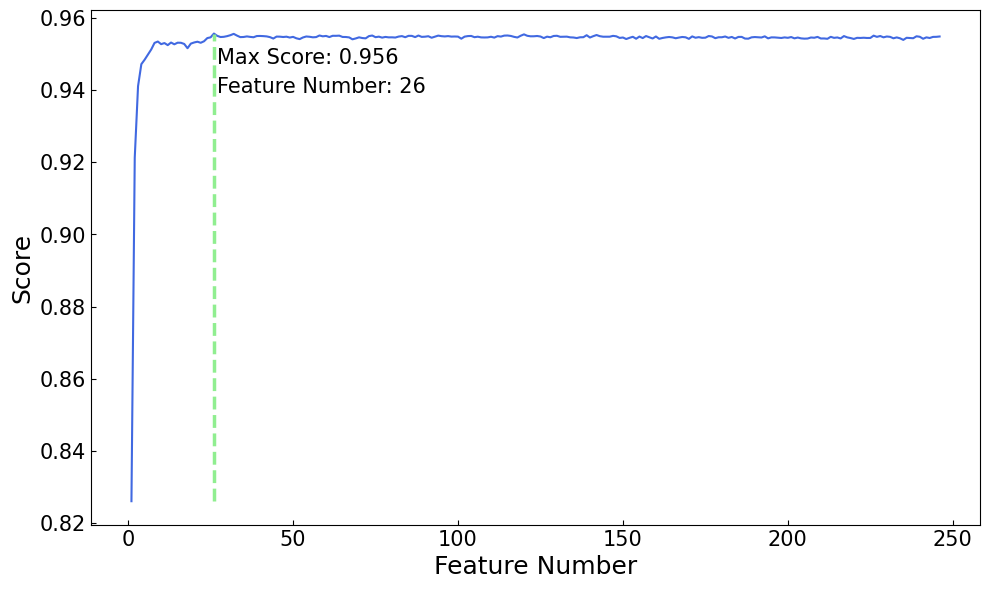

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 6)) 

y_r2 = selector.cv_results_['mean_test_score']
x_1_index = [item + 1 for item in range(len(y_r2))]

max_index = np.argmax(y_r2) + 1
max_score = np.max(y_r2)

plt.plot(x_1_index, y_r2, c='royalblue')

plt.plot([max_index, max_index], [np.min(y_r2), max_score], c='lightgreen', linewidth=2.5, linestyle='--')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.text(max_index + 1, max_score - 0.004, f'Max Score: {max_score:.3f}', fontsize=15, verticalalignment='top')
plt.text(max_index + 1, max_score - 0.012, f'Feature Number: {max_index}', fontsize=15, verticalalignment='top')

plt.xlabel('Feature Number', fontsize=18)
plt.ylabel('Score', fontsize=18)

plt.tick_params(axis='both', which='both', direction='in', bottom=True, left=True)

plt.tight_layout()
plt.savefig('./RFECV-PhO.png', dpi=600)
plt.show()


# Model Training

Training set

In [9]:
from scipy.stats import pearsonr
val_Y = []
val_P = []
kfold = KFold(n_splits=10, shuffle=True, random_state=random_seed)
for train_idx,val_idx in kfold.split(X_train_val_scaled):
    train_x,val_x = X_scaled[:,sel_index][train_idx],X_scaled[:,sel_index][val_idx]
    train_y,val_y = y_train_val.iloc[train_idx],y_train_val.iloc[val_idx]
    val_P_ = []
    for try_ in range(10): 
        model.fit(train_x,train_y)
        val_p = model.predict(val_x)
        val_P_.append(val_p)
    val_P_ = np.mean(val_P_,axis=0)
    val_P.append(val_P_)
    val_Y.append(val_y)
val_P = np.concatenate(val_P)
val_Y = np.concatenate(val_Y)
mae = mean_absolute_error(val_Y,val_P)
r2 = r2_score(val_Y,val_P)
pearson_r,_ = pearsonr(val_Y,val_P)

print("MAE: %.4f, R2: %.4f, Pearson R: %.4f"%(mae,r2,pearson_r))

MAE: 0.1283, R2: 0.9590, Pearson R: 0.9793


In [58]:
plt.figure(figsize=(4.5,4.5))

plt.scatter(val_Y,val_P,c='royalblue')

plt.text(-3.2,2.6,'$R^2$: %.3f'%r2_score(val_Y,val_P),fontsize=16)
plt.text(-3.2,2.10,'Pearson R: %.3f'%pearsonr(val_Y,val_P)[0],fontsize=16)
plt.text(-3.2,1.6,'MAE: %.3f V'%mean_absolute_error(val_Y,val_P),fontsize=16)

plt.plot([y.min(),3],[y.min(),3],c='royalblue')
plt.xlabel('E $_{Exp}$ (V)',fontsize=16)
plt.ylabel('E $_{ML}$ (V)',fontsize=16)
plt.xticks([-3, -2, -1, 0,1,2,3],list(map(str,[-3, -2, -1, 0,1,2,3])),fontsize=14)
plt.yticks([-3, -2, -1,0,1,2,3],list(map(str,[-3, -2, -1, 0,1,2,3])),fontsize=14)

epsilon = 1e-10 
re_train = np.abs(val_P - val_Y) / (np.abs(val_Y) + epsilon)
accuracy_train = np.mean(re_train <= 0.3) * 100
accuracy_train1 = np.mean(re_train <= 0.2) * 100
plt.text(0,-2.0, f'RE±0.3: {accuracy_train:.2f}%', fontsize=14, fontstyle='italic', fontweight='bold') 
plt.text(0,-2.4, f'RE±0.2: {accuracy_train1:.2f}%', fontsize=14, fontstyle='italic', fontweight='bold')

plt.tick_params(bottom='on',left='on')
plt.tight_layout()
plt.savefig('./train-rdkit-II-RE.tif', dpi=600)  
plt.savefig('./train-rdkit-II-RE.png',dpi = 600)

Test Set

In [12]:
test_P = []
feature_importance = []
for _ in range(10):
    model.fit(X_scaled[:,sel_index],y_train_val)
    feature_importance.append(model.feature_importances_)
    test_p = model.predict(test_x[:,sel_index])
    test_P.append(test_p)
test_p = np.mean(test_P,axis=0)
feature_importance = np.mean(feature_importance,axis=0)
sel_feature_names = np.array(rdkit_II_columns)[sel_index + 1]
sorted_feature_index = np.argsort(feature_importance)
importance_desc_names = sel_feature_names[sorted_feature_index]
importance_of_sel_desc = feature_importance[sorted_feature_index]

r2 = r2_score(test_y,test_p)
pearson_r,_ = pearsonr(test_y,test_p)
mae = mean_absolute_error(test_y,test_p)
print("MAE: %.4f, R2: %.4f, Pearson R: %.4f"%(mae,r2,pearson_r))

MAE: 0.2518, R2: 0.8693, Pearson R: 0.9329


In [55]:
plt.figure(figsize=(4.5,4.5))

plt.scatter(test_y,test_p,c='yellowgreen')
plt.text(-3.2,2.6,'$R^2$: %.3f'%r2_score(test_y,test_p),fontsize=16)
plt.text(-3.2,2.1,'Pearson R: %.3f'%pearsonr(test_y,test_p)[0],fontsize=16)
plt.text(-3.2,1.6,'MAE: %.3f V'%mean_absolute_error(test_y,test_p),fontsize=16)
plt.plot([y.min(),3],[y.min(),3],c='yellowgreen')
plt.xlabel('E $_{Exp}$ (V)',fontsize=14)
plt.ylabel('E $_{ML}$ (V)',fontsize=14)
plt.xticks([-3, -2, -1, 0,1,2,3],list(map(str,[-3, -2, -1, 0,1,2,3])),fontsize=14)
plt.yticks([-3, -2, -1, 0,1,2,3],list(map(str,[-3, -2, -1, 0,1,2,3])),fontsize=14)

epsilon = 1e-10
re_test = np.abs(test_p - test_y) / (np.abs(test_y) + epsilon)
accuracy_test = np.mean(re_test <= 0.3) * 100
accuracy_test1 = np.mean(re_test <= 0.2) * 100
plt.text(0, -2.0, f'RE±0.3: {accuracy_test:.2f}%', fontsize=14, fontstyle='italic', fontweight='bold') 
plt.text(0, -2.4, f'RE±0.2: {accuracy_test1:.2f}%', fontsize=14, fontstyle='italic', fontweight='bold')
plt.tick_params(bottom='on',left='on')
plt.tight_layout()
plt.savefig('./test-rdkit-II-RE.tif', dpi=600)  
plt.savefig('./test-rdkit-II-RE.png',dpi =600)

# Linear model coefficient analysis

In [44]:
fig = plt.figure(figsize=(15,40))

plt.barh(importance_desc_names, importance_of_sel_desc, color='lightblue',align='center')
plt.xlabel('Feature Importance Scores',fontsize=19)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tick_params(left='on',bottom='on')
plt.tight_layout()
print()
plt.savefig('./Feature Importance Scores-all.png',dpi = 600)

In [46]:
import matplotlib.pyplot as plt
import numpy as np

sorted_indices = np.argsort(importance_of_sel_desc)[-5:] 
top_5_importance = np.array(importance_of_sel_desc)[sorted_indices] 
top_5_names = np.array(importance_desc_names)[sorted_indices]  

fig = plt.figure(figsize=(15, 8)) 

plt.barh(top_5_names, top_5_importance, color='lightblue', align='center')
plt.xlabel('Feature Importance Scores', fontsize=19)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tick_params(left='on', bottom='on')
plt.tight_layout()
plt.savefig('./Feature Importance Scores.png',dpi = 600)
plt.show()

In [47]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
def fixed_selector_transform(X):
    return X[:, sel_index]

fixed_selector = FunctionTransformer(fixed_selector_transform)

pipeline = Pipeline([
    ('scaler', scaler),
    ('fixed_selector', fixed_selector),
    ('model', model)
])

X_full = np.vstack((X.iloc[train_val_indices], X.iloc[full_test_index]))  
y_full = np.concatenate((y_train_val, test_y))

pipeline.fit(X_full, y_full)

import shap
import joblib

X_scaled_full = pipeline.named_steps['scaler'].transform(X_full)
X_selected_full = pipeline.named_steps['fixed_selector'].transform(X_scaled_full)

explainer = shap.TreeExplainer(pipeline.named_steps['model'])
shap_values = explainer.shap_values(X_selected_full)

joblib.dump(pipeline, 'Jrdkit-II.joblib')


['Jrdkit-II.joblib']

In [48]:
y_pred_full = pipeline.named_steps['model'].predict(X_selected_full)

selected_feature_names = importance_desc_names

y_true_aligned = y_full

compound_names = physorg_react_data_df['compound_name'].iloc[train_val_indices].reset_index(drop=True)

df = pd.DataFrame(X_scaled_full[:, sel_index], columns=selected_feature_names)

df.insert(0, 'Compound_Name', compound_names)

df['Predicted_Y'] = y_pred_full

df['True_Y'] = y_true_aligned

missing_true_y = df['True_Y'].isna().sum()
if missing_true_y > 0:
    print(f"发现 {missing_true_y} 个真实值的空白，尝试修复索引对齐...")

df = df.dropna(subset=['True_Y']).reset_index(drop=True)
print(df)
df.to_csv('rdkit-selected_features_and_predicted_y_with_true_y.csv', index=False)

        Compound_Name  ESPmin_2  SlogP_VSA8     Chi4v  SlogP_VSA1  ALIEmax_2  \
0    (pqx)2Irbiim+-ox -1.021312         1.0 -0.506198    0.939917   0.487233   
1       CpIrbpyCl+-ox -1.117979         1.0 -1.122869   -0.189676  -0.283318   
2        CpIrbpyH+-ox -1.117979         1.0 -1.189592   -0.189676  -0.283318   
3     Ir(1np)2acac-ox  0.414814         1.0 -0.511362   -0.775940  -1.105022   
4      Ir(1np)2dpm-ox  0.803219         1.0 -0.400181   -0.775940  -1.105022   
..                ...       ...         ...       ...         ...        ...   
931               NaN -1.332984        -1.0  2.551503   -1.319268   0.202845   
932               NaN  0.729562        -1.0  2.132027    0.375121   0.917954   
933               NaN  0.444025        -1.0  0.789805    0.375121   0.121827   
934               NaN  0.717833        -1.0  1.868935    0.375121   0.121827   
935               NaN -0.998058        -1.0  1.482139    1.495186   0.512809   

     Neg_Average_2  Length_Ratio_2  ALI

In [49]:
pipeline = joblib.load('Jrdkit-II.joblib')
full_External_index = sorted(list(set(External_index + External_index_db2)))
X_external = X.iloc[full_External_index]
y = physorg_react_data_df['YRed/Ox']
y_external = y.iloc[full_External_index]
ext_pred = pipeline.predict(X_external.to_numpy())
compound_names = physorg_react_data_df['compound_name']
compound_names_external = compound_names.iloc[full_External_index]

In [50]:
results = pd.DataFrame({
    'Compound Name': compound_names_external.values,
    'Predicted Value': ext_pred,
    'Eexp': y_external.values
})
print(results)

               Compound Name  Predicted Value  Eexp
0      Ir(dFphtl)2PytlBn+-ox        -1.068849 -1.57
1      Ir(dFphtl)2PytlPh+-ox        -1.050552 -1.49
2         Ir(dfppz)2Phtz+-ox        -1.214030 -1.12
3       Ir(Fphtl)2PytlBn+-ox        -1.154175 -1.58
4       Ir(Fphtl)2PytlPh+-ox        -1.173849  -1.5
..                       ...              ...   ...
97    Ir-tPhTAZ2-phpybi+-red         0.432545  0.66
98      Ir-tpy-bmbib-Cl+-red         0.744939   0.8
99       Ir-tpy-mbib-Cl+-red         0.718766  0.88
100   mer-Ir(dfppz)2(pf)-red         0.193370 -0.37
101  mer-Ir(dfppz)2(ptp)-red         0.182737 -0.32

[102 rows x 3 columns]


In [63]:
ext_r2 = r2_score(y_external,ext_pred)
ext_mae = mean_absolute_error(y_external,ext_pred)
ext_pearson_r = pearsonr(y_external,ext_pred)[0]

plt.figure(figsize=(4.5,4.5))

plt.scatter(y_external,ext_pred,c='#efae42')

plt.text(-3.2,2.6,'$R^2$: %.3f'%ext_r2,fontsize=16)
plt.text(-3.2,2.1,'Pearson R: %.3f'%ext_pearson_r,fontsize=16)
plt.text(-3.2,1.6,'MAE: %.3f V'%ext_mae,fontsize=16)

plt.plot([y.min(),3],[y.min(),3],c='#efae42')
plt.xlabel('E $_{Exp}$ (V)',fontsize=14)
plt.ylabel('E $_{ML}$ (V)',fontsize=14)
plt.xticks([-3, -2, -1, 0,1,2,3],list(map(str,[-3, -2, -1, 0,1,2,3])),fontsize=14)
plt.yticks([-3, -2, -1, 0,1,2,3],list(map(str,[-3, -2, -1, 0,1,2,3])),fontsize=14)
plt.tick_params(bottom='on',left='on')

epsilon = 1e-10
re_ext = np.abs(ext_pred - y_external) / (np.abs(y_external) + epsilon)
accuracy_ext = np.mean(re_ext <= 0.3) * 100
accuracy_ext1 = np.mean(re_ext <= 0.2) * 100
plt.text(0, -2.0, f'RE±0.3: {accuracy_ext:.2f}%', fontsize=14, fontstyle='italic', fontweight='bold') 
plt.text(0, -2.4, f'RE±0.2: {accuracy_ext1:.2f}%', fontsize=14, fontstyle='italic', fontweight='bold')
plt.tight_layout()
plt.savefig('./external-rdkit-II-RE.tif', dpi=600) 
plt.savefig('./external-rdkit-II-RE.png', dpi=600)